In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

/home/suriya/dcu/Group-Project


In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [6]:
hyperparams = {'Friis': {'Gr_dBi': -3.464561870341017,
  'Gt_dBi': 0.20597726357898227,
  'L': 2.1516474937337478,
  'Pt_dBm': 17.87357752441881,
  'f': 2403652319.6880946,
  'n': 2.930021915116384},
 'LinearApprox': {'N': 2.915682422144732, 'TX': 11.682119667187617},
 'LogNormal': {'Gr_dBi': -5.125678676280162,
  'Gt_dBi': -4.108101510558816,
  'L': 0.7656207801852686,
  'Pt_dBm': -1.8532796868212498,
  'f': 2463516474.7305307,
  'n': 3.7519240746066163}}

In [9]:
from src.data import apply_fn_to_bluetooth, mitre, matrix

mitre = pd.DataFrame(mitre().apply(apply_fn_to_bluetooth, axis=1, tunables=hyperparams).values.tolist())
matrix = pd.DataFrame(matrix().apply(apply_fn_to_bluetooth, axis=1, tunables=hyperparams).values.tolist())

100%|██████████| 14/14 [00:00<00:00, 14.71it/s]


In [13]:
from src.featutils import aggregate_features_from_folder
from src.features import radioprop

train_dir = "data/tc4tl_training_data_v1/tc4tl/data/train/"
train_key = pd.read_csv("data/tc4tl_training_data_v1/tc4tl/docs/tc4tl_train_key.tsv", sep="\t")
test_dir = "data/tc4tl_data_v5/tc4tl/data/test/"
test_key = pd.read_csv("data/tc4tl_test_key/tc4tl/docs/tc4tl_test_key.tsv", sep="\t")
dev_dir = "data/tc4tl_data_v5/tc4tl/data/dev/"
dev_key = pd.read_csv("data/tc4tl_data_v5/tc4tl/docs/tc4tl_dev_key.tsv", sep="\t")

trainset, pipe = aggregate_features_from_folder(train_dir, train_key, feat_fn=radioprop.extract_features,
                               postproc_fn=radioprop.postproc_feature_dicts, verbose=True, testing=0,
                               tunables=hyperparams)

Post-processing: zzzjbxhg_tc4tl20.csv: 100%|██████████| 15552/15552 [00:20<00:00, 759.79it/s]


In [14]:
feat_cols = [col for col in trainset.columns if col != 'DistanceFloat' ]
tr_X, tr_y = trainset[feat_cols], trainset['DistanceFloat']

In [16]:
mitre_processed = pd.DataFrame(pipe.transform(mitre)[:, :-1], columns=feat_cols)
mitre_processed['DistanceFloat'] = mitre['DistanceFloat']
matrix_processed = pd.DataFrame(pipe.transform(matrix)[:, :-1], columns=feat_cols)
matrix_processed['DistanceFloat'] = matrix['DistanceFloat']

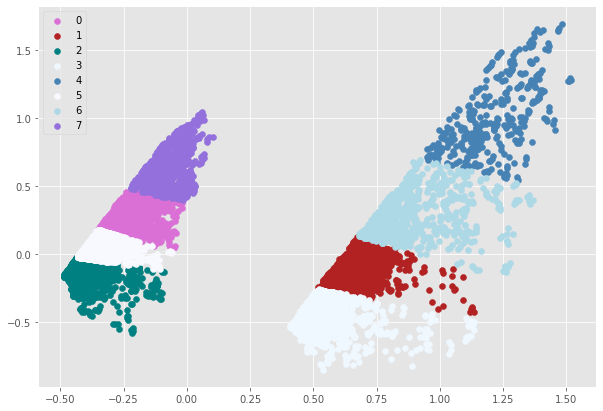

In [60]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from random import choice
from matplotlib import colors as mcolors

pca = PCA(2)
X_pca = pca.fit_transform(tr_X)
kmeans = KMeans(n_clusters=8, random_state=69)
label = kmeans.fit_predict(X_pca)

colors = list(mcolors.CSS4_COLORS.keys())
u_labels = np.unique(label)

plt.figure(figsize=(10, 7))
for i in u_labels:
    plt.scatter(X_pca[label == i , 0] , X_pca[label == i , 1] , label = i, c=choice(colors))
plt.legend()
plt.show()

In [63]:
X_aug = pd.concat([trainset, mitre_processed, matrix_processed])[feat_cols]

In [65]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from random import choice
from matplotlib import colors as mcolors


def plot(tr_X, n):
    pca = PCA(2)
    X_pca = pca.fit_transform(tr_X)
    kmeans = KMeans(n_clusters=n, random_state=69)
    label = kmeans.fit_predict(X_pca)

    colors = list(mcolors.CSS4_COLORS.keys())
    u_labels = np.unique(label)

    plt.figure(figsize=(10, 7))
    for i in u_labels:
        plt.scatter(X_pca[label == i , 0] , X_pca[label == i , 1] , label = i, c=choice(colors))
    plt.legend()
    plt.show()

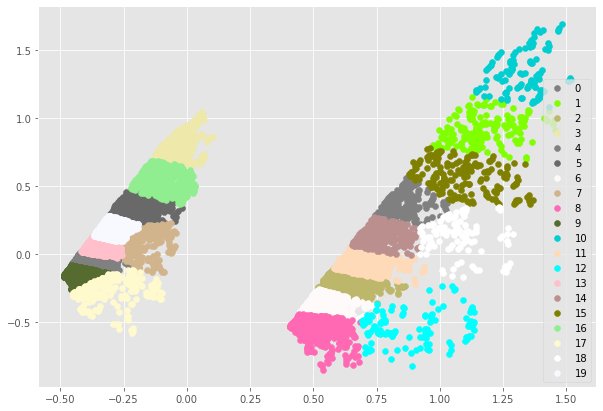

In [67]:
plot(tr_X, n=20)

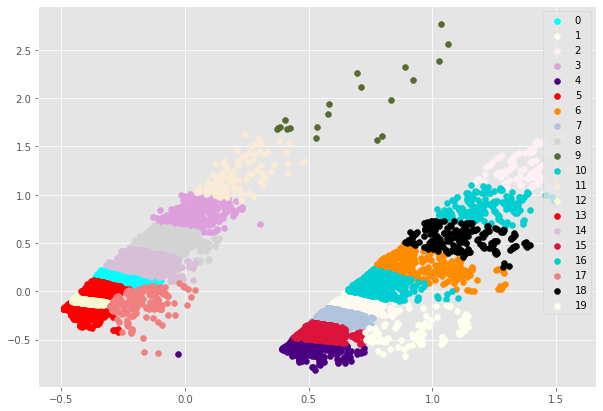

In [66]:
plot(X_aug, n=20)

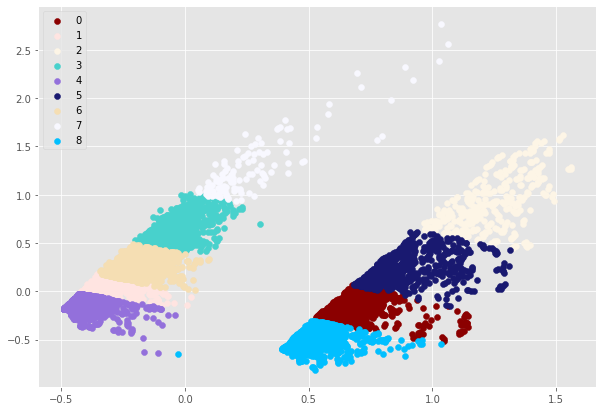

In [75]:
plot(X_aug, n=9)

## Dev Set

In [76]:
devset, _ = aggregate_features_from_folder(dev_dir, dev_key, feat_fn=radioprop.extract_features, pipe=pipe,
                               postproc_fn=radioprop.postproc_feature_dicts, verbose=True, testing=False,
                               tunables=hyperparams)

Post-processing: zzxttrqc_tc4tl20.csv: 100%|██████████| 935/935 [00:01<00:00, 735.85it/s]


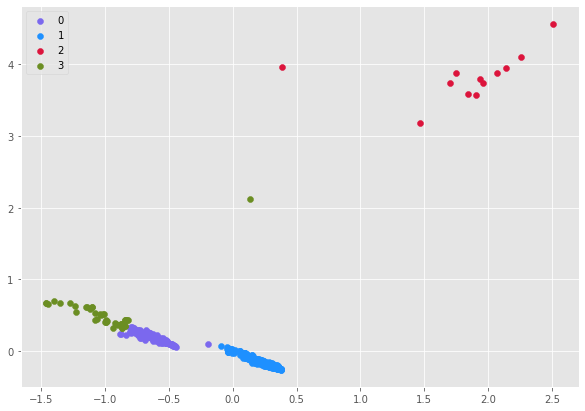

In [80]:
devX = devset[feat_cols]
plot(devX, 4)

## Test Set

In [81]:
testset, _ = aggregate_features_from_folder(test_dir, test_key, feat_fn=radioprop.extract_features, pipe=pipe,
                               postproc_fn=radioprop.postproc_feature_dicts, verbose=True, testing=False,
                               tunables=hyperparams)


Post-processing: zzzgwsci_tc4tl20.csv: 100%|██████████| 8423/8423 [00:11<00:00, 742.71it/s]


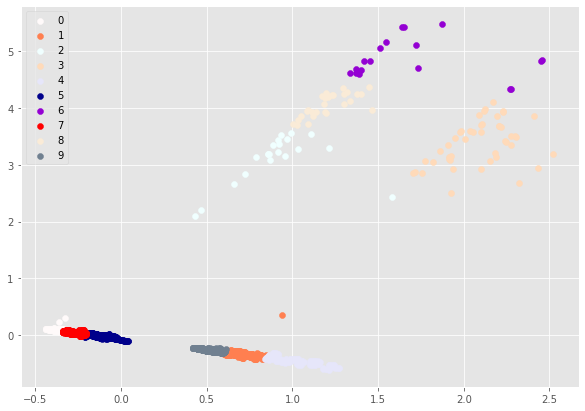

In [90]:
testX = testset[feat_cols]
plot(testX, 10)

## Compare

In [95]:
X_pca[:, 1].shape

(15552,)

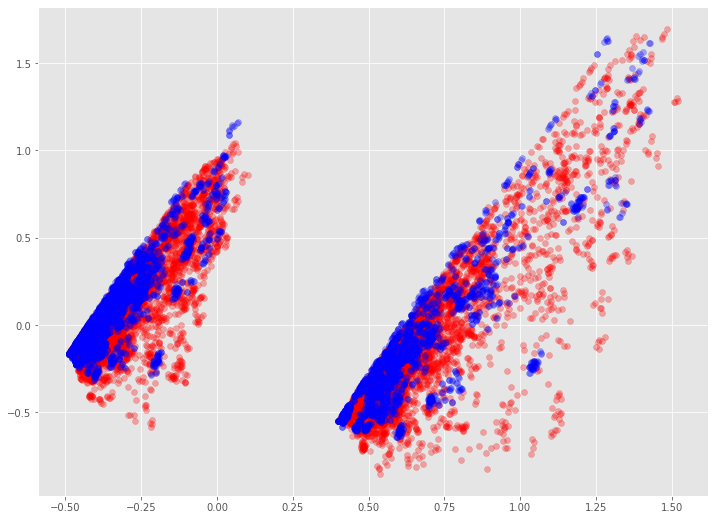

In [112]:
pca = PCA(2)
X_pca = pca.fit_transform(tr_X)
test_pca = pca.transform(testX)
dev_pca = pca.transform(devX)
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='red', alpha=0.3)
plt.scatter(test_pca[:, 0], test_pca[:, 1], c='blue', alpha=0.3);

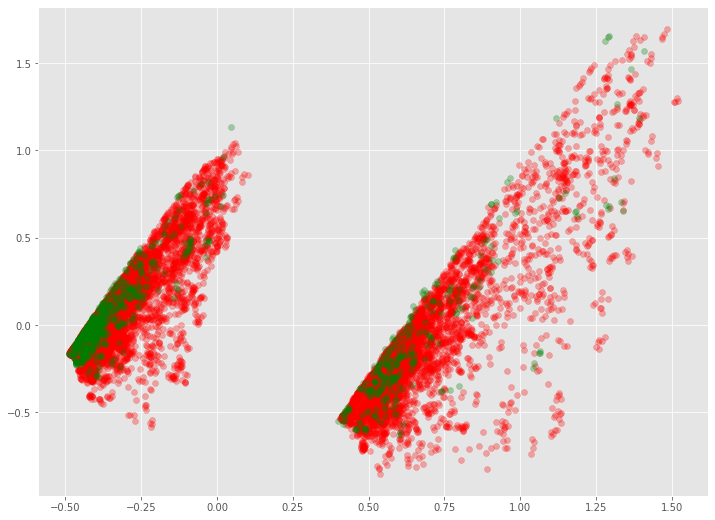

In [113]:
pca = PCA(2)
X_pca = pca.fit_transform(tr_X)
test_pca = pca.transform(testX)
dev_pca = pca.transform(devX)
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='red', alpha=0.3)
plt.scatter(dev_pca[:, 0], dev_pca[:, 1], c='green', alpha=0.3);

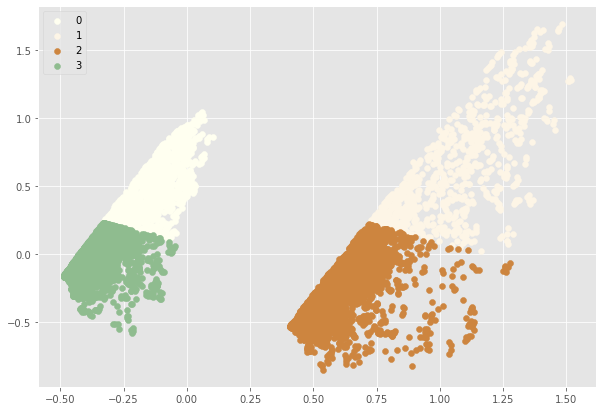

In [117]:
plot(tr_X, n=4)

## Train vs MITRE-MIT

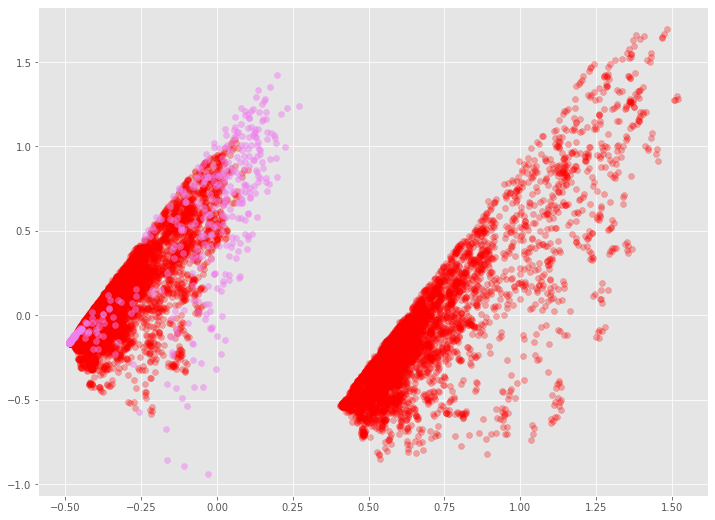

In [120]:
pca = PCA(2)
X_pca = pca.fit_transform(tr_X)
mitre_pca = pca.transform(mitre_processed[feat_cols])
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='red', alpha=0.3)
plt.scatter(mitre_pca[:, 0], mitre_pca[:, 1], c='violet', alpha=0.5);

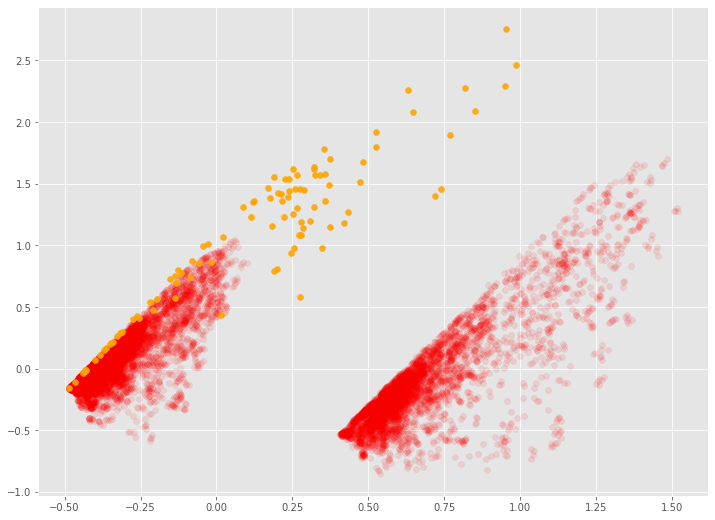

In [122]:
pca = PCA(2)
X_pca = pca.fit_transform(tr_X)
matrix_pca = pca.transform(matrix_processed[feat_cols])
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='red', alpha=0.1)
plt.scatter(matrix_pca[:, 0], matrix_pca[:, 1], c='orange', alpha=0.9);